In [1]:
from keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Lambda, Activation, BatchNormalization, LeakyReLU, Dropout, ZeroPadding2D, UpSampling2D
from keras.layers.merge import _Merge

from keras.models import Model, Sequential
from keras import backend as K
from keras.optimizers import Adam, RMSprop
from keras.utils import plot_model
from keras.initializers import RandomNormal

import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import mnist
from functools import partial


Using TensorFlow backend.


In [2]:
class RandomWeightedAverage(_Merge):
    def __init__(self, batch_size):
        super().__init__()
        self.batch_size = batch_size
    """Provides a (random) weighted average between real and generated image samples"""

    def _merge_function(self, inputs):
        alpha = K.random_uniform((self.batch_size, 1, 1, 1))
        return (alpha * inputs[0]) + ((1 - alpha) * inputs[1])


class GAN():
    def __init__(self
        , input_dim
        , discriminator_conv_filters
        , discriminator_conv_kernel_size
        , discriminator_conv_strides
        , generator_initial_dense_layer_size
        , generator_upsample
        , generator_conv_filters
        , generator_conv_kernel_size
        , generator_conv_strides
        , z_dim
        , batch_size
        ):

        self.input_dim = input_dim
        self.discriminator_conv_filters = discriminator_conv_filters
        self.discriminator_conv_kernel_size = discriminator_conv_kernel_size
        self.discriminator_conv_strides = discriminator_conv_strides

        self.generator_initial_dense_layer_size = generator_initial_dense_layer_size
        self.generator_upsample = generator_upsample
        self.generator_conv_filters = generator_conv_filters
        self.generator_conv_kernel_size = generator_conv_kernel_size
        self.generator_conv_strides = generator_conv_strides

        self.z_dim = z_dim
        self.n_layers_discriminator = len(discriminator_conv_filters)
        self.n_layers_generator = len(generator_conv_filters)
        self.batch_size = batch_size 

        self._build()
    def _build(self):
        
        ## Discriminator ##
        discriminator_input = Input(shape=self.input_dim)
        x =discriminator_input

        for i in range(self.n_layers_discriminator):
            conv_layer = Conv2D(
                filters= self.discriminator_conv_filters[i],
                kernel_size = self.discriminator_conv_kernel_size[i],
                strides = self.discriminator_conv_strides[i],
                padding = 'same', 
            )
            x = conv_layer(x)
            x = Activation('relu')(x)
            x = Dropout(rate=0.4)(x)

        x = Flatten()(x)
        discriminator_output = Dense(1,activation='sigmoid',kernel_initializer='random_normal')(x)

        self.discriminator = Model(discriminator_input,discriminator_output)

        ## Generator ##

        generator_input =Input(shape =(self.z_dim,))
        x = generator_input

        x = Dense(np.prod(self.generator_initial_dense_layer_size))(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Reshape(self.generator_initial_dense_layer_size)(x)
        x = Dropout(rate=0.4)(x)

        for i in range(self.n_layers_generator):
            if self.generator_upsample[i] == 2:
                x = UpSampling2D()(x)
                conv_layer = Conv2D(
                    filters = self.generator_conv_filters[i],
                    kernel_size = self.generator_conv_kernel_size[i],
                    padding = 'same'
                )
                x = conv_layer(x)
            else:
                conv_layer = Conv2DTranspose(
                    filters = self.generator_conv_filters[i],
                    kernel_size = self.generator_conv_kernel_size[i],
                    padding = 'same'
                )
                x = conv_layer(x)
            if i < self.n_layers_generator -1:
                x = BatchNormalization()(x)
                x = Activation('relu')(x)
            else:
                x = Activation('sigmoid')(x)
        
        generator_output = x
        self.generator = Model(generator_input,generator_output)



        ## WGAN-GP
        real_img = Input(shape=self.input_dim)
        z_disc = Input(shape =(self.z_dim, ))
        fake_img = self.generator(z_disc)

        fake = self.discriminator(fake_img)
        valid = self.discriminator(real_img)

        interpolated_img = RandomWeightedAverage(self.batch_size)([real_img,fake_img])
        validity_interpolated =self.discriminator(interpolated_img)

        gp_loss = partial(self.gradient_penalty_loss, samples = interpolated_img)
        
        self.critic_model = Model(inputs=[real_img, z_disc], outputs=[
                                  valid, fake, validity_interpolated])

        ############ COMPILE ##################
        
        ## Discriminator Compile ##
        # self.discriminator.trainable = True
        # self.discriminator.compile(
        #     optimizer = RMSprop(lr = 0.0008),
        #     loss = self.wasserstein
        # )
        ## Generator Compile
        self.generator.compile(
            optimizer=RMSprop(lr=0.0008),
            loss = self.wasserstein
        )
        # self.generator.trainable =False
        # For freezing discriminator Weight , 
        

        self.generator.trainable = False
        # In training critics, generator not training
        self.critic_model.compile(
            loss = [self.wasserstein,self.wasserstein,gp_loss],
            optimizer =Adam(lr=0.0008,beta_1=0.5),
            loss_weights=[1, 1, 10]
        )


        # model

        self.discriminator.trainable = False
        self.generator.trainable = True

        model_input = Input(shape=(self.z_dim,))
        model_output = self.discriminator(self.generator(model_input))
        self. model = Model(model_input,model_output)
        # Compile Model
        self.model.compile(
            optimizer=RMSprop(lr=0.0004),
            loss = self.wasserstein,
            metrics =['accuracy']
        )

        self.discriminator.trainable = True

        ## train GAN ##

    def train_discriminator(self,x_train,batch_size):
        valid = np.ones((batch_size,1))
        fake = -np.ones((batch_size, 1))

        idx = np.random.randint(0,x_train.shape[0],batch_size)
        true_image = x_train[idx]
        #print(true_image.shape)
        self.discriminator.train_on_batch(true_image,valid)
        # True Image for 1

        noise = np.random.normal(0,1,(batch_size,self.z_dim))
        self.gen_image = self.generator.predict(noise)
        #print(gen_image.shape)
        self.discriminator.train_on_batch(self.gen_image,fake)
        # False Image for -1

        for layer in self.discriminator.layers:
            weights = layer.get_weights()
            weights = [np.clip(w,-0.01,0.01) for w in weights]
            layer.set_weights(weights)

    def train_critics(self,x_train,batch_size):
        valid = np.ones((batch_size, 1), dtype=np.float32)
        fake = -np.ones((batch_size,1), dtype=np.float32)
        dummy = np.zeros((batch_size, 1), dtype=np.float32)

        idx = np.random.randint(0, x_train.shape[0], batch_size)
        true_image = x_train[idx]

        noise = np.random.normal(0, 1, (batch_size, self.z_dim))
        self.critic_model.train_on_batch([true_image,noise],[valid,fake,dummy])



    def train_generator(self,batch_size):
        valid  = np.ones((batch_size,1))
        noise = np.random.normal(0, 1, (batch_size, self.z_dim))
        self.model.train_on_batch(noise,valid)


    def train(self, x_train, epoch):
        for i in range(epoch):
            for _ in range(5):
                self.train_critics(x_train,self.batch_size)
            self.train_generator(self.batch_size)
            print(i,end=" ")
            
            if i%100 == 0 :
                znew = np.random.normal(0,1,size=(1, gan.z_dim))
                plt.imshow(self.generator.predict(znew)[0],cmap='gray')
                plt.show()
    
    def wasserstein(self,y_true,y_pred):
        return K.mean(y_true * y_pred)

    def gradient_penalty_loss(self,y_true,y_pred,samples, sample_weight = None ):
        gradients = K.gradients(y_pred, samples)[0]
        gradient_l2_norm = K.sqrt(
            K.sum(
                K.square(gradients),
                axis = list(range(1,len(gradients.shape))
                )
            )
        )
        return K.mean(K.square(1 - gradient_l2_norm))


/home/sjo506/.local/lib/python3.6/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/home/sjo506/.local/lib/python3.6/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 

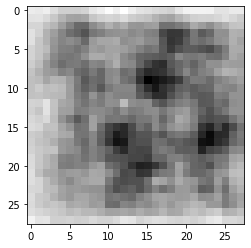

/home/sjo506/.local/lib/python3.6/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 

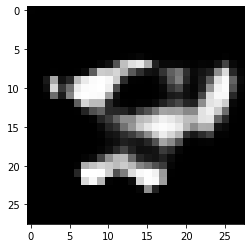

101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 

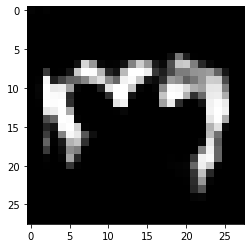

201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 277 278 279 280 281 282 283 284 285 286 287 288 289 290 291 292 293 294 295 296 297 298 299 300 

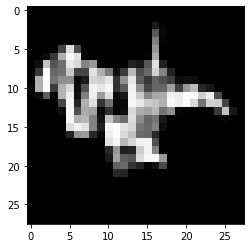

301 302 303 304 305 306 307 308 309 310 311 312 313 314 315 316 317 318 319 320 321 322 323 324 325 326 327 328 329 330 331 332 333 334 335 336 337 338 339 340 341 342 343 344 345 346 347 348 349 350 351 352 353 354 355 356 357 358 359 360 361 362 363 364 365 366 367 368 369 370 371 372 373 374 375 376 377 378 379 380 381 382 383 384 385 386 387 388 389 390 391 392 393 394 395 396 397 398 399 400 

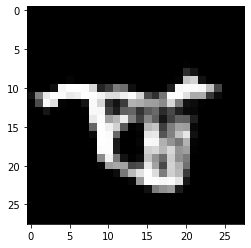

401 402 403 404 405 406 407 408 409 410 411 412 413 414 415 416 417 418 419 420 421 422 423 424 425 426 427 428 429 430 431 432 433 434 435 436 437 438 439 440 441 442 443 444 445 446 447 448 449 450 451 452 453 454 455 456 457 458 459 460 461 462 463 464 465 466 467 468 469 470 471 472 473 474 475 476 477 478 479 480 481 482 483 484 485 486 487 488 489 490 491 492 493 494 495 496 497 498 499 500 

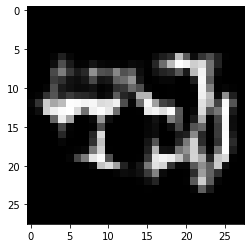

501 502 503 504 505 506 507 508 509 510 511 512 513 514 515 516 517 518 519 520 521 522 523 524 525 526 527 528 529 530 531 532 533 534 535 536 537 538 539 540 541 542 543 544 545 546 547 548 549 550 551 552 553 554 555 556 557 558 559 560 561 562 563 564 565 566 567 568 569 570 571 572 573 574 575 576 577 578 579 580 581 582 583 584 585 586 587 588 589 590 591 592 593 594 595 596 597 598 599 600 

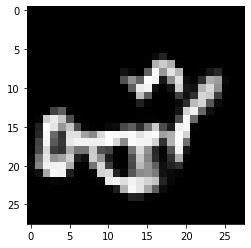

601 602 603 604 605 606 607 608 609 610 611 612 613 614 615 616 617 618 619 620 621 622 623 624 625 626 627 628 629 630 631 632 633 634 635 636 637 638 639 640 641 642 643 644 645 646 647 648 649 650 651 652 653 654 655 656 657 658 659 660 661 662 663 664 665 666 667 668 669 670 671 672 673 674 675 676 677 678 679 680 681 682 683 684 685 686 687 688 689 690 691 692 693 694 695 696 697 698 699 700 

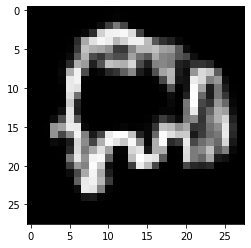

701 702 703 704 705 706 707 708 709 710 711 712 713 714 715 716 717 718 719 720 721 722 723 724 725 726 727 728 729 730 731 732 733 734 735 736 737 738 739 740 741 742 743 744 745 746 747 748 749 750 751 752 753 754 755 756 757 758 759 760 761 762 763 764 765 766 767 768 769 770 771 772 773 774 775 776 777 778 779 780 781 782 783 784 785 786 787 788 789 790 791 792 793 794 795 796 797 798 799 800 

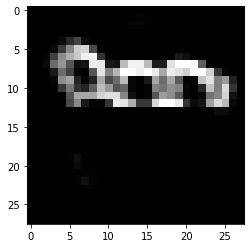

801 802 803 804 805 806 807 808 809 810 811 812 813 814 815 816 817 818 819 820 821 822 823 824 825 826 827 828 829 830 831 832 833 834 835 836 837 838 839 840 841 842 843 844 845 846 847 848 849 850 851 852 853 854 855 856 857 858 859 860 861 862 863 864 865 866 867 868 869 870 871 872 873 874 875 876 877 878 879 880 881 882 883 884 885 886 887 888 889 890 891 892 893 894 895 896 897 898 899 900 

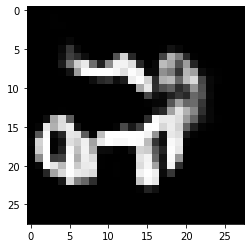

901 902 903 904 905 906 907 908 909 910 911 912 913 914 915 916 917 918 919 920 921 922 923 924 925 926 927 928 929 930 931 932 933 934 935 936 937 938 939 940 941 942 943 944 945 946 947 948 949 950 951 952 953 954 955 956 957 958 959 960 961 962 963 964 965 966 967 968 969 970 971 972 973 974 975 976 977 978 979 980 981 982 983 984 985 986 987 988 989 990 991 992 993 994 995 996 997 998 999 1000 

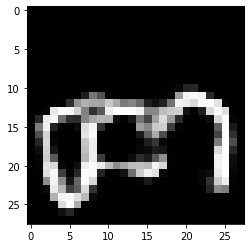

1001 1002 1003 1004 1005 1006 1007 1008 1009 1010 1011 1012 1013 1014 1015 1016 1017 1018 1019 1020 1021 1022 1023 1024 1025 1026 1027 1028 1029 1030 1031 1032 1033 1034 1035 1036 1037 1038 1039 1040 1041 1042 1043 1044 1045 1046 1047 1048 1049 1050 1051 1052 1053 1054 1055 1056 1057 1058 1059 1060 1061 1062 1063 1064 1065 1066 1067 1068 1069 1070 1071 1072 1073 1074 1075 1076 1077 1078 1079 1080 1081 1082 1083 1084 1085 1086 1087 1088 1089 1090 1091 1092 1093 1094 1095 1096 1097 1098 1099 1100 

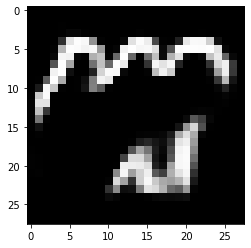

1101 1102 1103 1104 1105 1106 1107 1108 1109 1110 1111 1112 1113 1114 1115 1116 1117 1118 1119 1120 1121 1122 1123 1124 1125 1126 1127 1128 1129 1130 1131 1132 1133 1134 1135 1136 1137 1138 1139 1140 1141 1142 1143 1144 1145 1146 1147 1148 1149 1150 1151 1152 1153 1154 1155 1156 1157 1158 1159 1160 1161 1162 1163 1164 1165 1166 1167 1168 1169 1170 1171 1172 1173 1174 1175 1176 1177 1178 1179 1180 1181 1182 1183 1184 1185 1186 1187 1188 1189 1190 1191 1192 1193 1194 1195 1196 1197 1198 1199 1200 

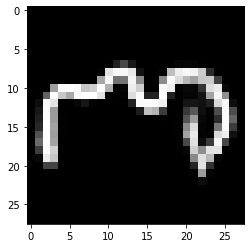

1201 1202 1203 1204 1205 1206 1207 1208 1209 1210 1211 1212 1213 1214 1215 1216 1217 1218 1219 1220 1221 1222 1223 1224 1225 1226 1227 1228 1229 1230 1231 1232 1233 1234 1235 1236 1237 1238 1239 1240 1241 1242 1243 1244 1245 1246 1247 1248 1249 1250 1251 1252 1253 1254 1255 1256 1257 1258 1259 1260 1261 1262 1263 1264 1265 1266 1267 1268 1269 1270 1271 1272 1273 1274 1275 1276 1277 1278 1279 1280 1281 1282 1283 1284 1285 1286 1287 1288 1289 1290 1291 1292 1293 1294 1295 1296 1297 1298 1299 1300 

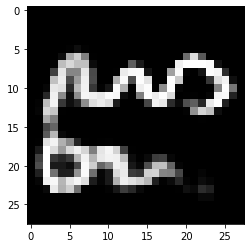

1301 1302 1303 1304 1305 1306 1307 1308 1309 1310 1311 1312 1313 1314 1315 1316 1317 1318 1319 1320 1321 1322 1323 1324 1325 1326 1327 1328 1329 1330 1331 1332 1333 1334 1335 1336 1337 1338 1339 1340 1341 1342 1343 1344 1345 1346 1347 1348 1349 1350 1351 1352 1353 1354 1355 1356 1357 1358 1359 1360 1361 1362 1363 1364 1365 1366 1367 1368 1369 1370 1371 1372 1373 1374 1375 1376 1377 1378 1379 1380 1381 1382 1383 1384 1385 1386 1387 1388 1389 1390 1391 1392 1393 1394 1395 1396 1397 1398 1399 1400 

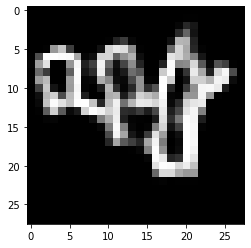

1401 1402 1403 1404 1405 1406 1407 1408 1409 1410 1411 1412 1413 1414 1415 1416 1417 1418 1419 1420 1421 1422 1423 1424 1425 1426 1427 1428 1429 1430 1431 1432 1433 1434 1435 1436 1437 1438 1439 1440 1441 1442 1443 1444 1445 1446 1447 1448 1449 1450 1451 1452 1453 1454 1455 1456 1457 1458 1459 1460 1461 1462 1463 1464 1465 1466 1467 1468 1469 1470 1471 1472 1473 1474 1475 1476 1477 1478 1479 1480 1481 1482 1483 1484 1485 1486 1487 1488 1489 1490 1491 1492 1493 1494 1495 1496 1497 1498 1499 1500 

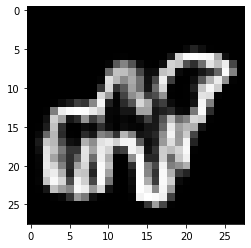

1501 1502 1503 1504 1505 1506 1507 1508 1509 1510 1511 1512 1513 1514 1515 1516 1517 1518 1519 1520 1521 1522 1523 1524 1525 1526 1527 1528 1529 1530 1531 1532 1533 1534 1535 1536 1537 1538 1539 1540 1541 1542 1543 1544 1545 1546 1547 1548 1549 1550 1551 1552 1553 1554 1555 1556 1557 1558 1559 1560 1561 1562 1563 1564 1565 1566 1567 1568 1569 1570 1571 1572 1573 1574 1575 1576 1577 1578 1579 1580 1581 1582 1583 1584 1585 1586 1587 1588 1589 1590 1591 1592 1593 1594 1595 1596 1597 1598 1599 1600 

/home/sjo506/.local/lib/python3.6/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/sjo506/.local/lib/python3.6/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/sjo506/.local/lib/python3.6/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/home/sjo506/.local/lib/python3.6/site-packages/matplotlib/image.py:478: UserWarning: Warning: converting a masked element to nan.
  dtype=scaled_dtype)


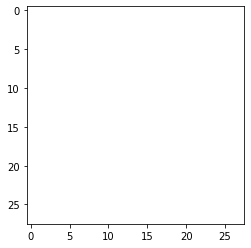

1601 1602 1603 1604 1605 1606 1607 1608 1609 1610 1611 1612 1613 1614 1615 1616 1617 1618 1619 1620 1621 1622 1623 1624 1625 1626 1627 1628 1629 1630 1631 1632 1633 1634 1635 1636 1637 1638 1639 1640 1641 1642 1643 1644 1645 1646 1647 1648 1649 1650 1651 1652 1653 1654 1655 1656 1657 1658 1659 1660 1661 1662 1663 1664 1665 1666 1667 1668 1669 1670 1671 1672 1673 1674 1675 1676 1677 1678 1679 1680 1681 1682 1683 1684 1685 1686 1687 1688 1689 1690 1691 1692 1693 1694 1695 1696 1697 1698 1699 1700 

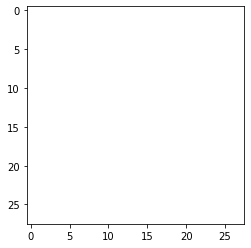

1701 1702 1703 1704 1705 1706 1707 1708 1709 1710 1711 1712 1713 1714 1715 1716 1717 1718 1719 1720 1721 1722 1723 1724 1725 1726 1727 1728 1729 1730 1731 1732 1733 1734 1735 1736 1737 1738 1739 1740 1741 1742 1743 1744 1745 1746 1747 1748 1749 1750 1751 1752 1753 1754 1755 1756 1757 1758 1759 1760 1761 1762 1763 1764 1765 1766 1767 1768 1769 1770 1771 1772 1773 1774 1775 1776 1777 1778 1779 1780 1781 1782 1783 1784 1785 1786 1787 1788 1789 1790 1791 1792 1793 1794 1795 1796 1797 1798 1799 1800 

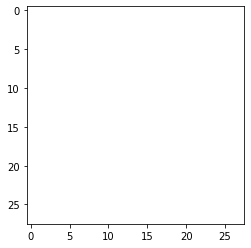

1801 1802 1803 1804 1805 1806 1807 1808 1809 1810 1811 1812 1813 1814 1815 1816 1817 1818 1819 1820 1821 1822 1823 1824 1825 1826 1827 1828 1829 1830 1831 1832 1833 1834 1835 1836 1837 1838 1839 1840 1841 1842 1843 1844 1845 1846 1847 1848 1849 1850 1851 1852 1853 1854 1855 1856 1857 1858 1859 1860 1861 1862 1863 1864 1865 1866 1867 1868 1869 1870 1871 1872 1873 1874 1875 1876 1877 1878 1879 1880 1881 1882 1883 1884 1885 1886 1887 1888 1889 1890 1891 1892 1893 1894 1895 1896 1897 1898 1899 1900 

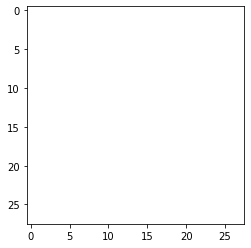

1901 1902 1903 1904 1905 1906 1907 1908 1909 1910 1911 1912 1913 1914 1915 1916 1917 1918 1919 1920 1921 1922 1923 1924 1925 1926 1927 1928 1929 1930 1931 1932 1933 1934 1935 1936 1937 1938 1939 1940 1941 1942 1943 1944 1945 1946 1947 1948 1949 1950 1951 1952 1953 1954 1955 1956 1957 1958 1959 1960 1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 

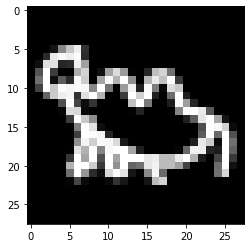

In [3]:
gan = GAN(input_dim = (28,28,1)
        , discriminator_conv_filters = [64,64,128,128]
        , discriminator_conv_kernel_size = [5,5,5,5]
        , discriminator_conv_strides = [2,2,2,1]
        , generator_initial_dense_layer_size = (7, 7, 64)
        , generator_upsample = [2,2, 1, 1]
        , generator_conv_filters = [128,64, 64,1]
        , generator_conv_kernel_size = [5,5,5,5]
        , generator_conv_strides = [1,1, 1, 1]
        , z_dim = 100
        , batch_size = 64
        )

data = np.load("/home/sjo506/Gan_practice/test/camel/camel.npy")
data = data/255.0
data = np.reshape(data,(len(data),28,28,1))
gan.train(data,2000)
plt.imshow(data[0],cmap = 'gray')
plt.show()